# Exploration and estimation of monazite CHIME dating results

In [1]:
%gui qt5

In [2]:
%matplotlib qt5

these non-builtin libraries will be used in notebook:
* pandas -- for convinient way of excel file importing
* numpy -- the python workhorse to work with multidimentional arrays, we use it here mostly as fallback mode when pandas misbeahave
* scipy --  we use some basic gaussian generating functions
* matplotlib -- de facto standard ploting library
* pyqtgraph -- interactive ploting (optimal)
* peakutils -- finding and estimating the center of gaussian peaks
* statsmodel -- basic statistics

In [3]:
import pandas as pd
import numpy as np
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = (10.0, 8.0) #change this if it is too big/too small for your screen
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
#import pyqtgraph as pg

from math import exp, sqrt
import statsmodels.api as sm
import struct

import peakutils

import scipy.stats as stats

import glob
import os

/home/petras/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


main radioctive decay constants needed for later calculations:

In [5]:
#constructing the used values container:

class Container(object):
    pass

elem = Container()
lmbd = Container()
lmbd.U238 = Container()
lmbd.U235 = Container()
lmbd.Th232 = Container()
# values by Jaffey et al 1971!!!
lmbd.U238.value = 1.55125E-10
lmbd.U238.two_sigma = 0.00107
lmbd.U235.value = 9.8485E-10
lmbd.U235.two_sigma =  0.00136
lmbd.Th232.value = 4.9475E-11
lmbd.Th232.two_sigma = 0.00017
elem.lmbd = lmbd
elem.U238_U235 = 137.88 #U238/U235
#CHIME calc ratios to convert wt to atom:
elem.K_Th = 0.896405   
elem.K_U8 = 0.859157
elem.K_U5 = 0.006261

# we just constructed tree like object elem, which contains constants, which items can be called by dot notation:
# i.e. lambda U238 value can be called by: elem.lmbd.U238.value

###### 1. import the data into pandas dataframe, initial filtering:

We use relative paths in this notebook to the files, please keep the directory structure intact of the ESM after uncompressing it. The EMPA data in excel format is in the same directory thus we are opening it with pandas very simply. Please note, the bellow action have to be modified if excel file record header starts not at 0 line. Also it will work only when horizontal headers are value type, and records changes verticaly.

In [6]:
#creating datasets:
weight = pd.read_excel('P84_monazite.xls', sheetname='weight')
stddev = pd.read_excel('P84_monazite.xls', sheetname='stddev')

### Textures

The below class defineshow to read EMPA BSE images saved in Cameca compact binary format (*.ipmDat)

In [10]:
class CamecaImage_from_ipmDat(object):
    def __init__(self, filename):
        with open(filename, 'br') as fn:
            fn.seek(0x50)
            self.stage_x, self.stage_y, self.beam_x, self.beam_y,\
              self.res, _, self.width, self.height = struct.unpack('iiiiffII',fn.read(8*4))
            fn.seek(552)
            img_str = fn.read(self.width*self.height)
            self.img = np.fromstring(img_str, dtype=np.uint8).reshape(self.height, self.width)

lets make list of images (using glob built-in library):

In [11]:
image_list = glob.glob('Images/*.impDat')
image_list.sort()

In [12]:
#unfortunatelly matplotlib have no robust scalebar, thus we create class which we will use with images:

from matplotlib.patches import Rectangle
from matplotlib.offsetbox import AnchoredOffsetbox, AuxTransformBox, VPacker, TextArea, DrawingArea

class AnchoredSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None,
                 frameon=True, color='r',textsize=10):
        """
        Draw a horizontal bar with the size in data coordinate of the give axes.
        A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), size, 0, fc="None",ec=color))

        self.txt_label = TextArea(label,
                                  textprops={'color':color, 'fontsize':textsize},
                                  minimumdescent=False)

        self._box = VPacker(children=[self.size_bar, self.txt_label],
                            align="center",
                            pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=self._box,
                                   prop=prop,
                                   frameon=frameon)

In [39]:
print(weight.columns.values)

['P' 'Y' 'La' 'Ce' 'Pr' 'Nd' 'Sm' 'Gd' 'Dy' 'Er' 'Pb' 'Ca' 'Th' 'U' 'Si'
 'O' 'Total' 'Age (Ma)' 'Age err' 'Comment' 'Point#' 'X' 'Y.1' 'Z' 'Date']


Differently than in spreadsheet programs, with 'pandas' we acces data by column names, thus dublicated names get extended by dot and number – It depends from the order in which the Y (Ytrium) and stage Y is saved in the table. Only the first
column header preserves its form, later ones are extended (i.e. second collumn with 'Y', will be renamed to 'Y.1')

In [40]:
#plot the all  images with analytical point overlay:
#for j in range(len(image_list)):
    
def plot_cameca_overlayed(image_path, dataset=None, value=None, val_err=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(os.path.basename(image_path))
    image = CamecaImage_from_ipmDat(image_path)
    range_img = (image.stage_x - image.width * image.res/2,   #  left
                         image.stage_x + image.width * image.res/2,   #  right
                         image.stage_y - image.height * image.res/2,
                         image.stage_y + image.height * image.res/2) 
    img = plt.imshow(image.img, cmap='gray',
                 extent=range_img) #  top
    ax.set_xlabel('stage x coordinates [$\mu m$]')
    ax.set_ylabel('stage y coordinates [$\mu m$]')
    asb = AnchoredSizeBar(ax.transData,
                          100,
                          "$100\mu m$",
                          loc=4,
                          pad=0.1, borderpad=0.5, sep=5,
                          frameon=False,
                          color='w')
    
    if dataset is not None:
        try:
            stageX = dataset.X
            #we need to deal with Ytrium and Y stage variables, as in excel both are saved with Y header
            if dataset.Y.dtype == 'int64':
                stageY = dataset.Y
            else:
                stageY = dataset['Y.1']
            for i in dataset.index:
                if stageX[i] > range_img[0] and stageX[i] < range_img[1] and stageY[i] > range_img[2] and stageY[i] < range_img[3]:
                    ax.plot(dataset.X[i], stageY[i], 'ro')
                if value is not None:
                    if val_err is not None:
                        anot = '{0:d}+/-{1:d}'.format(value[i], val_err[i])
                    else:
                        anot = str(value[i])
                    ax.annotate(anot, (stageX[i], stageY[i]), color='r')
        except AttributeError:
            print('The provided dataset have no stage possition')
    ax.set_xlim(range_img[:2])
    ax.set_ylim(range_img[2:])
    ax.add_artist(asb)

    plt.show()

In [41]:
#using above function,
#plot only image:
plot_cameca_overlayed(image_path=image_list[0])
#plot image with point:
plot_cameca_overlayed(image_path=image_list[0], dataset=weight)
#plot image with points with U concentration as annotations for points:
plot_cameca_overlayed(image_path=image_list[0], dataset=weight, value=weight['U'])
#finally, image with points with age and age error:
plot_cameca_overlayed(image_path=image_list[0], dataset=weight,
                      value=weight['Age (Ma)'], val_err=weight['Age err'])

In [42]:
#to plot all age images with spot ages we would use:
for i in image_list:
    plot_cameca_overlayed(image_path=i, dataset=weight,
                          value=weight['Age (Ma)'], val_err=weight['Age err'])

/home/petras/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [44]:
plt.close('all')  # to close all opened plot windows with one cmd.

#### Filtering the chemical data: 

We should get rid of the analyses with very low Pb, to prevent the absurd outcome. For that we will use 2sigma values. We want to leave just points where value.Pb - 2sigma.Pb > 0 for further calculations.


In [8]:
two_sigma_filter = weight.Pb - 2*stddev.Pb > 0
print('number of points before filtering:', weight['P'].count())
weight, stddev = weight[two_sigma_filter], stddev[two_sigma_filter]
print('number of points after 2sigma filtering:', weight['P'].count())

number of points before filtering: 154
number of points after 2sigma filtering: 136


We can subset the dataset by different value fields (i.e. by Comment):

###### 2.plot sorted dates:

In [63]:
plt.plot(np.sort(weight['Age (Ma)']),'+')
plt.ylabel('Age [Ma]')
plt.show() #optional call for interactive plotting

###### 2b. plot sorted dates with age errors:

In [60]:
weight.sort_values('Age (Ma)', inplace=True)

reindex sorted dataset:

In [61]:
weight.index = range(1,len(weight) + 1)

In [47]:
weight.Comment.unique()

array(['Namaqualand', ' '], dtype=object)

above example shows two unique values: empty string and 'Namaqualand' - the standard, so the whole dataset can be subset into two:

In [64]:
weight_sample = weight[weight.Comment != 'Namaqualand']
stddev_sample = stddev[stddev.Comment != 'Namaqualand']
weight_std = weight[weight.Comment == 'Namaqualand']
stddev_std = stddev[stddev.Comment == 'Namaqualand']

In [65]:
weight_sample

,P,Y,La,Ce,Pr,Nd,Sm,Gd,Dy,Er,...,O,Total,Age (Ma),Age err,Comment,Point#,X,Y.1,Z,Date
1,12.2611,1.0902,15.0059,25.3357,2.1551,6.9715,0.9936,0.5598,0.2839,0.0011,...,26.7231,98.4408,270,107,,64,16060,-1880,-94,2015-09-12 02:48:41
2,12.2469,1.0468,15.9228,26.0809,2.0737,6.2933,0.6768,0.2714,0.1935,0.0158,...,26.6726,98.2128,271,108,,146,15748,-3834,-73,2015-09-12 16:02:08
3,12.4318,1.3265,15.7842,26.1752,2.1152,6.5993,0.7411,0.2730,0.2043,0.0315,...,26.7222,97.9436,275,131,,136,15758,-3820,-74,2015-09-12 14:25:15
4,12.0949,1.5177,15.0871,25.5158,2.0437,6.3964,0.6430,0.3708,0.2440,0.0505,...,26.6160,98.1475,288,98,,118,16471,-3600,-67,2015-09-12 11:30:44
5,12.0326,1.7622,15.0725,25.7165,2.1118,6.6145,0.7510,0.4048,0.2961,0.0549,...,26.3454,97.3908,289,115,,87,16155,-2096,-89,2015-09-12 06:30:50
6,12.4113,1.2646,15.6879,26.5448,2.1950,6.7413,0.8252,0.3925,0.2515,0.0000,...,26.8128,98.3661,290,144,,61,16047,-1848,-94,2015-09-12 02:19:38
7,12.0244,1.3558,14.3411,24.5585,2.2051,7.1316,0.9293,0.4812,0.2580,0.0170,...,26.7397,98.9667,290,87,,107,16489,-3579,-67,2015-09-12 09:44:16
8,12.1296,1.1678,14.8966,25.2064,2.0475,6.8063,0.9912,0.5737,0.3179,0.0075,...,26.6035,98.1034,291,104,,63,16051,-1871,-94,2015-09-12 02:39:04
9,12.2012,1.1474,15.4640,25.9034,2.1557,6.4387,0.6627,0.2800,0.2241,0.0000,...,26.7228,98.7170,291,97,,120,16432,-3617,-67,2015-09-12 11:50:03
10,12.4706,1.2815,15.7908,26.2753,2.1634,6.5563,0.6669,0.3019,0.1975,0.0044,...,26.7626,97.9987,292,132,,57,15971,-1878,-94,2015-09-12 01:41:06


In [66]:
# weighted average age for studied sample,
#   where weight for average used is the inversion of error size: 
age = np.average(weight_sample['Age (Ma)'],
           weights=1/weight_sample['Age err'])
age_std = np.mean(weight_std['Age (Ma)'])
print('%6.2f' % age, 'Ma\tP84')
print('%6.2f' % age_std, 'Ma\tNamaqualand median')

327.49 Ma	P84
952.44 Ma	Namaqualand median


In [74]:
plt.hlines(1033,weight_std.index[0]-1,weight_std.index[-1]+1,colors='red', label='Namaqualand know age')
plt.vlines(weight.index, weight['Age (Ma)']-weight['Age err'],
           weight['Age (Ma)']+weight['Age err'],label='age errors')
plt.hlines(age, -1, weight_sample.index[-1]+1, colors='green', label='weighted average of P84')
plt.plot(weight.index, weight['Age (Ma)'],'+', label='age')
plt.ylabel('Age [Ma]')
plt.grid()
plt.legend(loc=0)
plt.show() #optional call if interactive plotting

In [75]:
plt.close()

In [115]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(weight_sample['Age (Ma)'],'+-')
ax1.set_ylabel('Age [Ma]')
ax1.grid()
ax2 = fig.add_subplot(312, sharex=ax1)
ax2.plot(weight_sample.index[1:],np.ediff1d(weight_sample['Age (Ma)']),'-', label='diff_age')
ax2.grid()
ax3 = fig.add_subplot(313, sharex=ax1)
#ax3.plot(weight_sample.La/weight_sample.Nd, 'r-')
ax3.plot(weight_sample.Nd, 'g-')

In [122]:
group1 = weight[(weight['Age (Ma)']> 285)&(weight['Age (Ma)']< 320)]
group2 = weight[(weight['Age (Ma)']> 320)&(weight['Age (Ma)']< 370)]

In [123]:
age1 = np.average(group1['Age (Ma)'],weights=1/group1['Age err'])
age2 = np.average(group2['Age (Ma)'],weights=1/group2['Age err'])
print(age1, age2)

303.616851958 342.732138072


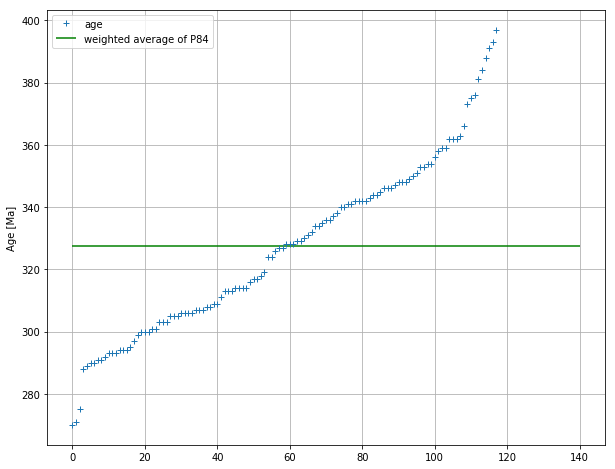

In [20]:
fig = plt.figure()
plt.hlines(age, 0,140, colors='green', label='weighted average of P84')
plt.plot(np.sort(weight_KZ['Age (Ma)']),'+', label='age')
plt.ylabel('Age [Ma]')
plt.grid()
plt.legend(loc=0)
plt.show() #optional call if interactive plotting

notice the small gap at 320Ma!

In [19]:
plt.close()

###### 2c. plot binary diagrams to get preliminary view about chemical composition ranges

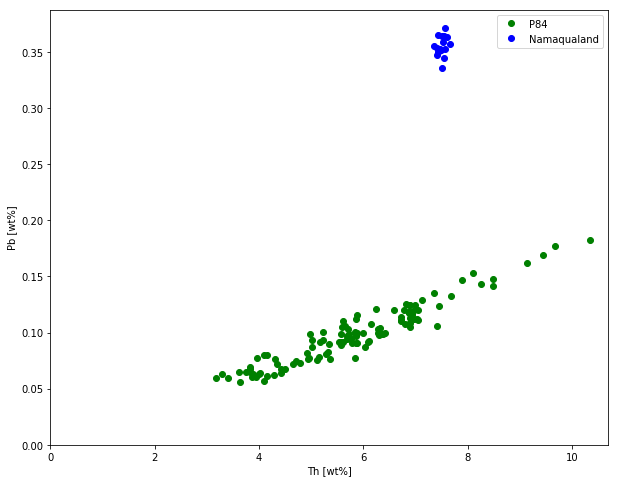

In [21]:
plt.plot(weight_KZ.Th,weight_KZ.Pb,'go',label='P84')
plt.plot(weight_std.Th,weight_std.Pb,'bo',label='Namaqualand')
plt.xlabel('Th [wt%]')
plt.ylabel('Pb [wt%]')
plt.xlim(0)
plt.ylim(0)
plt.legend()
plt.show()

In [28]:
plt.close()

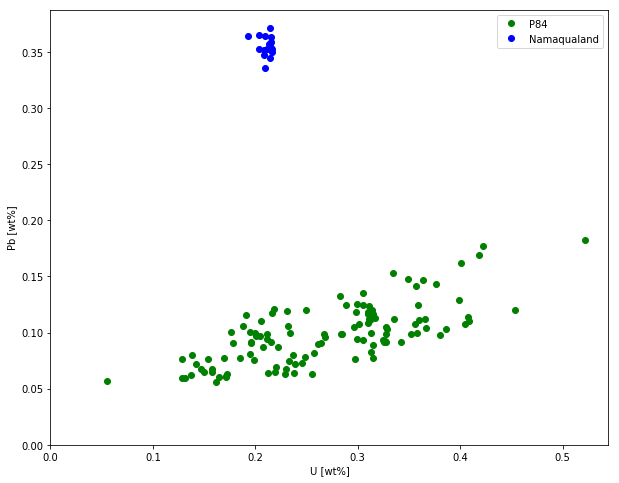

In [22]:
plt.plot(weight_KZ.U,weight_KZ.Pb,'go',label='P84')
plt.plot(weight_std.U,weight_std.Pb,'bo',label='Namaqualand')
plt.xlabel('U [wt%]')
plt.ylabel('Pb [wt%]')
plt.xlim(0)
plt.ylim(0)
plt.legend()
plt.show()

In [30]:
plt.close()

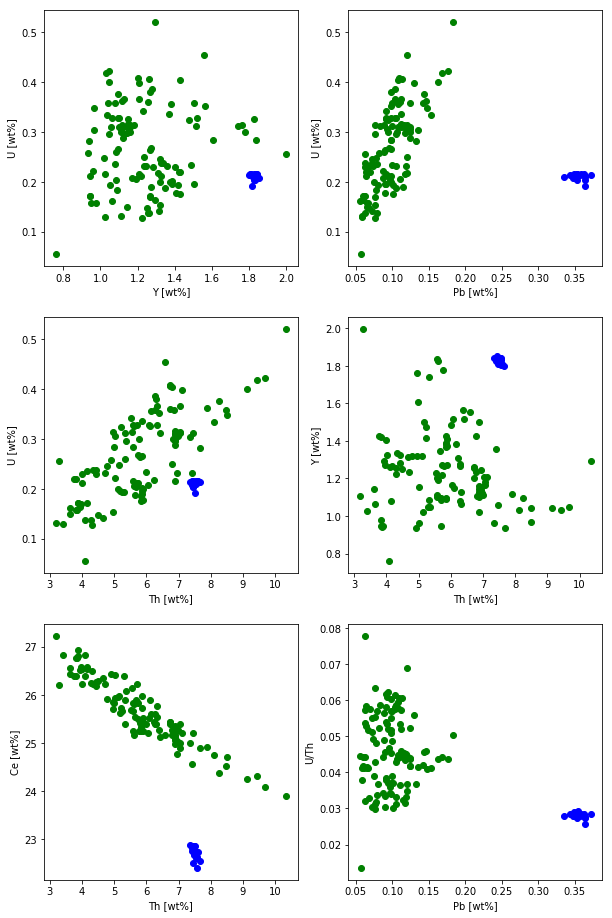

In [23]:
fig = plt.figure(figsize=(10,16))
ax1 = fig.add_subplot(321)
ax1.plot(weight_KZ.Y,weight_KZ.U,'go')
ax1.plot(weight_std.Y,weight_std.U,'bo')
ax1.set_xlabel('Y [wt%]')
ax1.set_ylabel('U [wt%]')
ax2 = fig.add_subplot(322)
ax2.plot(weight_KZ.Pb,weight_KZ.U,'go')
ax2.plot(weight_std.Pb,weight_std.U,'bo')
ax2.set_xlabel('Pb [wt%]')
ax2.set_ylabel('U [wt%]')
ax3 = fig.add_subplot(323)
ax3.plot(weight_KZ.Th,weight_KZ.U,'go')
ax3.plot(weight_std.Th,weight_std.U,'bo')
ax3.set_xlabel('Th [wt%]')
ax3.set_ylabel('U [wt%]')
ax4 = fig.add_subplot(324)
ax4.plot(weight_KZ.Th,weight_KZ.Y,'go')
ax4.plot(weight_std.Th,weight_std.Y,'bo')
ax4.set_xlabel('Th [wt%]')
ax4.set_ylabel('Y [wt%]')
ax5 = fig.add_subplot(325)
ax5.plot(weight_KZ.Th,
         weight_KZ.Ce
         ,'go',label='P84')
ax5.plot(weight_std.Th,weight_std.Ce,'bo')
ax5.set_xlabel('Th [wt%]')
ax5.set_ylabel('Ce [wt%]')
ax6 = fig.add_subplot(326)
ax6.plot(weight_KZ.Pb,
         weight_KZ.U/weight_KZ.Th,'go')
ax6.plot(weight_std.Pb,
         weight_std.U/weight_std.Th,'bo')
ax6.set_xlabel('Pb [wt%]')
ax6.set_ylabel('U/Th')
plt.show()

In [32]:
plt.close()

We construct the age iterator to calculate ages independantly from Cameca's black box algorithms:

In [24]:
def iterage(Pb, Th, U, initial_age=300e6,n_iter=100):
    age = initial_age
    Pb_calc = Th*elem.K_Th*(exp(elem.lmbd.Th232.value*age)-1) + U * (elem.K_U8*(exp(elem.lmbd.U238.value*age)-1) + elem.K_U5*(exp(elem.lmbd.U235.value*age)-1))
    for i in range(n_iter):
        age /= Pb_calc/Pb
        Pb_calc = Th*elem.K_Th*(exp(elem.lmbd.Th232.value*age)-1) + U * (elem.K_U8*(exp(elem.lmbd.U238.value*age)-1) + elem.K_U5*(exp(elem.lmbd.U235.value*age)-1))
        if Pb_calc/Pb == 1.0: #break out from for loop if Pb calculated equals Pb measured
            break
    return(age/1e6)

###### 3a. statistical distribution of the corrected sample ages:

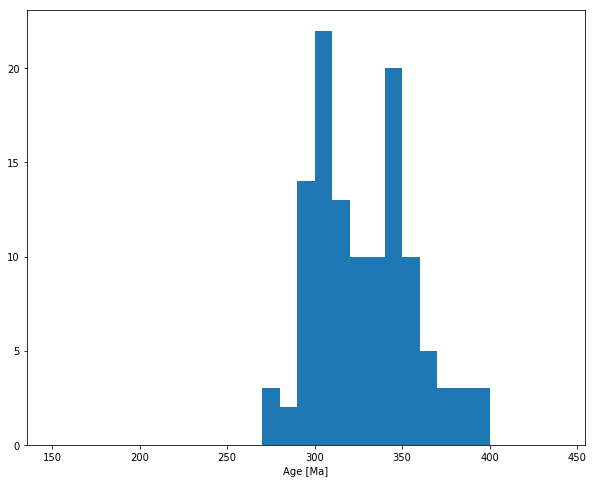

In [27]:
plt.hist(np.asanyarray(weight_KZ['Age (Ma)']), normed=False,  #<-- Cameca outputed ages!!!
         bins=np.arange(150.,450.,10.))
plt.xlabel('Age [Ma]')
plt.show()

Above graph looks like binomial distribution. Lets plot histogram, however histograms are not best representation method of the distribution, lets additionaly use kernel density estimation function with gaussian kernel.
The gausian kernel bandwidth is by default estimated by by Scott(1992) method in used statsmodel package.

In [30]:
plt.close()

In [90]:
kde_gauss = sm.nonparametric.KDEUnivariate(np.asanyarray(weight_sample['Age (Ma)'], dtype=np.double))
kde_gauss.fit()
plt.plot(kde_gauss.support,kde_gauss.density)
plt.hist(weight_sample['Age (Ma)'],normed=True,
         bins=np.arange(150.,450.,10))
plt.xlabel('Age [Ma]')
plt.grid()
plt.show()

kde tends to oversmooth binomial close distributions, we could tweak (lower with factor of 0.6) the bandwich with adjusting gaussian fit:

In [13]:
plt.close()

In [91]:
kde_gauss.fit(adjust=0.6)
plt.plot(kde_gauss.support,kde_gauss.density)
plt.hist(weight_sample['Age (Ma)'],normed=True,color='0.8',
         bins=np.arange(150.,450.,5)) # also we reduced bin size for histogram
plt.xlabel('Age [Ma]')
plt.grid()
plt.show()

Above clearly shows binomial distribution of ages!

However it can be wishful to construct traditional density plot with taking into acount the age errors.
For that we will use probability density function (pdf) from scipy.stats package imported at the top.

At first lets create dummy array with time span for pdf, lets say from 50 to 550 with time step of 0.5Ma:

In [93]:
dummy = np.arange(50,550,0.5)

the kernel function requires 1 sigma, so to represent the age error as gaussian function we will provide function with the age error value divided by 3, bellow graph represents the relation gauss distribution and different sigma values and Cameca's age error:

In [95]:
fit = stats.norm.pdf(dummy, weight_sample['Age (Ma)'][3], weight_sample['Age err'][3]/3)
plt.vlines([weight_sample['Age (Ma)'][3]]-weight_sample['Age err'][3]/np.asarray([3,1.5,1]),0,[0.006,0.0013,0.0001],'0.5')
plt.text(weight_sample['Age (Ma)'][3]- weight_sample['Age err'][3]/3,0.006,'1$\sigma$')
plt.text(weight_sample['Age (Ma)'][3]- weight_sample['Age err'][3]/1.5,0.0013,'2$\sigma$')
plt.text(weight_sample['Age (Ma)'][3]- weight_sample['Age err'][3],0.0003,'3$\sigma$')
plt.plot(weight_sample['Age (Ma)'][3],0.001,'o')
plt.errorbar(weight_sample['Age (Ma)'][3],0.001,xerr=weight_sample['Age err'][3])
plt.plot(dummy,fit,'k-')
#plt.yscale('log')
plt.show()

In [18]:
plt.close()

Plotting all results with error as one sigma:

In [97]:
for i in weight_sample.index:
    fit = stats.norm.pdf(dummy, weight_sample['Age (Ma)'][i], weight_sample['Age err'][i]/3)
    plt.plot(dummy,fit, c=(0,0,0,0.2)) #color RGBA value
plt.show()

From this part what we are trying to do is something similar as described by Săbău and Negulescu (2013) and called "pooling", but  with less mathematical, more graphical and easier undersandable to anyone way.

In [34]:
plt.close()

2nd step would be to plot the sum of the above pdf's, but it will show not much. We skip it and go step further: divide the sum by number of analyses to get average of pdf's  (cumulative average). If dates have normal distribution when our cumulative average should fit the gaussian function fited directly to the point distribution, where center of such function is the mean of population, and sigma of such function is calculated directly from the whole population:

In [98]:
cumulate = np.zeros_like(fit)
for i in weight_sample.index:
    fit = stats.norm.pdf(dummy, weight_sample['Age (Ma)'][i], weight_sample['Age err'][i]/3)
    cumulate += fit
    plt.plot(dummy,fit,c=(0,0,0,0.1))

plt.plot(dummy,cumulate/len(weight_sample),'r',label='cumulative average',lw=3)
gauss_whole = stats.norm.pdf(dummy,np.mean(weight_sample['Age (Ma)']),np.std(weight_sample['Age (Ma)']))
plt.plot(dummy, gauss_whole,'g-',lw=3, label='normal distribution fited to the weighted mean\n using std.dev. of whole population')
plt.xlabel('Age [Ma]')
plt.legend()
plt.grid()
plt.show()

In [34]:
plt.close()

The huge mismach between gausian fit for whole population and cumulative average pdf shows that data rather have not strict normal distribution.
If we try to fit the cummulative average by decreasing error weights we are starting to get signs of binomial distribution:

In [103]:
cumulate = np.zeros_like(fit)
for i in weight_sample.index:
    fit = stats.norm.pdf(dummy, weight_sample['Age (Ma)'][i], weight_sample['Age err'][i]/8) #decreesing error by changing 3 -> 7
    cumulate += fit
    plt.plot(dummy,fit,c=(0,0,0,0.1))

plt.plot(dummy,cumulate/len(weight_sample.Y),c=(1,0,0,0.8),label='cumulative average',lw=3)
gauss_whole = stats.norm.pdf(dummy,np.mean(weight_sample['Age (Ma)']),np.std(weight_sample['Age (Ma)']))
plt.plot(dummy, gauss_whole,c=(0,0.5,0,0.8),lw=3, label='normal distribution of population\n fitted gauss')
plt.legend()
plt.grid()
plt.ylim(0,0.02)
plt.xlim(100,500)
plt.xlabel('Age [Ma]')
plt.show()

From the above graph it is clear that weighted mean of whole population of dates would be meaningless, and for sure monazites recorded few thermal stages, thus we should try to resolve the dates of that stages.

We could try some semi-automatic (rather manual) "deconvolution" of density plot produced with gausian kernel, or cummulative average with reduced sigmas/point. We want to point that in well know examples where division of two events is well described by textural and chemical distinctions, unmodified cumulative pdf shows just one event.

<b>pesimistic simple model:</b>

At the begining we could feed the pdf function with decreased sigma values so instead of 3/7 as above we will use 3/8. Notation '3/' are used here because age error is treated as 3sigmas.

In [ ]:
dummy = np.arange(150,450,0.5) #the discrete age range from 150 to 450 with step of 0.5
kde_gauss.fit()   # the previously calculated kde pdf
fig = plt.figure()
fig.suptitle('pesimistic-simple model')
ax1=fig.add_subplot(211)
ax1.plot(kde_gauss.support,kde_gauss.density, lw=2, label='gaussian KDE')
ax1.set_xlabel('Age [Ma]')
cumulate = np.zeros_like(dummy)
for i in weight_KZ.index:
    fit = stats.norm.pdf(dummy, weight_KZ['Age (Ma)'][i], weight_KZ['Age err'][i]/8) # <-- 3/8 sigma
    cumulate += fit
ax1.plot(dummy,cumulate/len(weight_KZ),c=(1,0,0,0.8),label='cumulative average\n with 3/8',lw=3) 
indexes = peakutils.indexes(kde_gauss.density, thres=0.1, min_dist=10)
peaks_x = peakutils.interpolate(kde_gauss.support, kde_gauss.density,ind=indexes, width=4)
print('automaticly, recognised age peaks from gaussian kde:', peaks_x)
indexes = peakutils.indexes(cumulate/len(weight_KZ), thres=0.16, min_dist=10)
peaks_x = peakutils.interpolate(dummy, cumulate/len(weight_KZ),ind=indexes, width=4)
print('automaticly, recognised age peaks from sharpened cumulative pdf:', peaks_x)
indexes = [310, 385]  
#print('manualy provided indexes:', indexes)
peaks_x = [304, 343]
print('manually selected age peaks:', peaks_x)
ax1.vlines(peaks_x,0,(cumulate/len(weight_KZ))[indexes],linestyle='--')
proportion = [0.485,0.4]
hights = list((cumulate/len(weight_KZ))[indexes])
sum_peak = np.zeros_like(dummy)
one_sigma = [18, 16] # <----- this value we need to chose manualy to make the best fiting
for i in range(len(peaks_x)):
    ax1.annotate(s=str(int(round(peaks_x[i]))), xy=(peaks_x[i]-6,0.0005+(cumulate/len(weight_KZ))[indexes[i]]))
    peak = stats.norm.pdf(dummy,peaks_x[i],one_sigma[i])*proportion[i]
    ax1.plot(dummy,peak,'0.5')
    sum_peak += peak
    
ax1.plot(dummy, sum_peak, label='sum of deconv. peaks',lw=2)
ax1.legend(loc=(2))
ax2 = fig.add_subplot(212)
ax2.plot(weight_KZ['Age (Ma)'],weight_KZ['Age err'],'o')
ax2.set_xlim(150,450)
ax2.set_ylabel('raw Cameca age errors [Ma]')
ax2.set_xlabel('Age [Ma]')
plt.show()
print('The 2 major  thermal events: 304.5+/-18 Ma, 342.5+/-16 Ma')

In [68]:
plt.close('all')

There is problem with peakutils-library for peak search. It finds the tips at the cumulative curve, but that is not exact tip of the population, thus we have to adjust ages manually to get best fit.

We could estimate errors of those populations. In most common situations population error can be reduced by error propagation:
$$\sigma_p^2 = \frac{1}{\sum\limits_{i=1}^n \frac{1}{\sigma_i^2}}$$
where it is calculated using data from every point.
By deconvolution we however can't tell wich analytical point is from which population and use its error due to overlap (as shown in the above graph) of normal distributions of those populations. Knowing the total amount of analyses, manualy chosen sigma for populations, and fraction of main population we can modify the above equation:
$$\sigma_p = \sqrt{\frac{\sigma_{p_{teo}}^2}{f*N}}$$
where f is fraction(proportion) of population deduced by fitting/deconvoluting cumulative pdf, and $\sigma_{p_{teo}}$ - manually fitted sigma for the population.

In [ ]:
fig = plt.figure()
fig.suptitle('geology based - deconvoluted model',fontsize=16)
ax1=fig.add_subplot(111)
ax1.set_xlabel('Age [Ma]')
ax1.grid()
cumulate = np.zeros_like(dummy)
for i in weight_KZ.index:
    fit = stats.norm.pdf(dummy, weight_KZ['Age (Ma)'][i], weight_KZ['Age err'][i]/8) # <-- 3/8 sigma
    cumulate += fit
ax1.plot(dummy,cumulate/len(weight_KZ),c=(1,0,0,0.8),label='cumulative average\n with 3/8 of sigma/point',lw=3) 
indexes = [310, 360, 387, 397]   
peaks_x = np.asanyarray([304., 330., 342.5,350.]) # <<-- manualy entered dates
print('manualy selected age peaks:', peaks_x)
ax1.vlines(peaks_x,0,(cumulate/len(weight_KZ))[indexes],linestyle='--')
proportion = np.asanyarray([0.392,0.17,0.188,0.25]) # <<-- manualy chosen height fraction
hights = list((cumulate/len(weight_KZ))[indexes])
sum_peak = np.zeros_like(dummy)
one_sigma = np.asanyarray([18., 35., 14., 30.]) # <----- manualy chosen one sigma values
for i in range(len(peaks_x)):
    ax1.annotate(s=str(int(round(peaks_x[i]))),
                 xy=(peaks_x[i]-6,0.0005+(cumulate/len(weight_KZ))[indexes[i]]))
    peak = stats.norm.pdf(dummy,peaks_x[i],one_sigma[i])*proportion[i]
    ax1.plot(dummy,peak,'0.5')
    sum_peak += peak
    
ax1.plot(dummy, sum_peak, label='sum of deconv. peaks',lw=2)
ax1.legend(loc=(2))
ax1.set_ylim(0,0.013)
sigma2_err = np.sqrt((one_sigma*2) ** 2 / (proportion * weight_KZ.X.count()))
plt.show()
for i in range(len(peaks_x)):
    print('{0:6.1f} +/-{1:6.1f} Ma'.format(peaks_x[i],sigma2_err[i]))

In [99]:
plt.close()

<p><b>The conclusions from those graphs and statistical treatment:</b></p>
1. studied monazites from P84 recorded 2 main thermal events at ~304 and 342-344 with probable inheritance of Jawornik granitoid ages of 350Ma, and thermally modified ages down to 330Ma, which agrees well with zircon dating.

### 4. subseting population according to chemical differences:

As we saw before above, there are something going in binary diagrams of element concentrations, the most visible spread is in U vs Pb digrams, thus we could subgroup the whole population into few throught the visible gap in U vs Pb binary graph. Also we can check in 3D if there are more than one populations visible (U vs Th vs Pb):

In [100]:
from mpl_toolkits.mplot3d import Axes3D

(hint: you can interact with the plot by dragging mouse with left button -- rotates the cube; right button -- zooms)


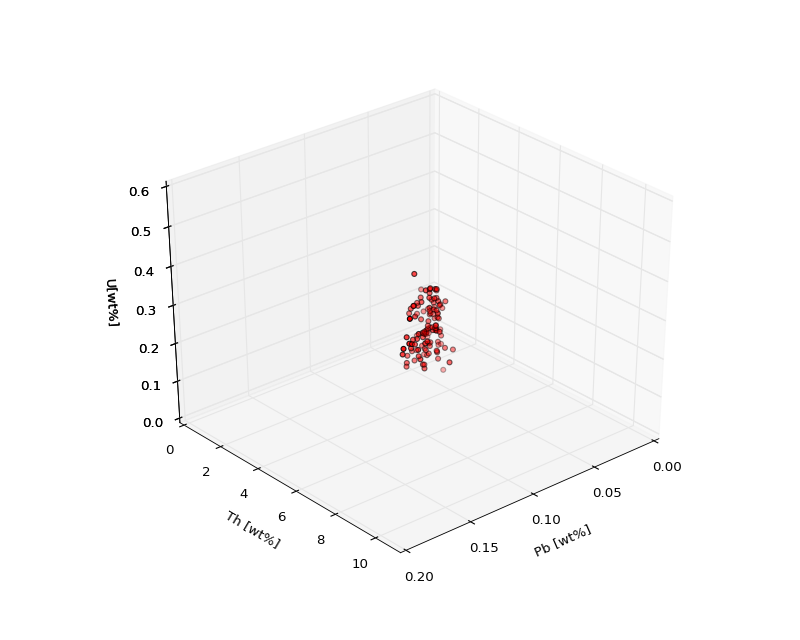

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weight_KZ.Pb, weight_KZ.Th, weight_KZ.U,
           c='r', marker='o')
ax.set_xlabel('Pb [wt%]')
ax.set_ylabel('Th [wt%]')
ax.set_zlabel('U[wt%]')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_zlim(0)
plt.show()

by rotating and aligning cube so that (0,0,0) point would be behind them. From the point cload shape in that perspective, we can say that there is signs of two populations of points, which partialy overlaps! So the bimodality is not visible in ages but also chemistry!

In [106]:
ax.view_init(elev=33, azim=49)
plt.draw()  # this affects the above graph

In [107]:
plt.close()

How to discriminate the population? Looking to 3D diagram populations changes with U content, however they overlaps in Th vs Pb space. So to get right plane for discrimination we will merge Pb with Th, so the division between those two populations should be easiest done in U vs Th+Pb diagram:


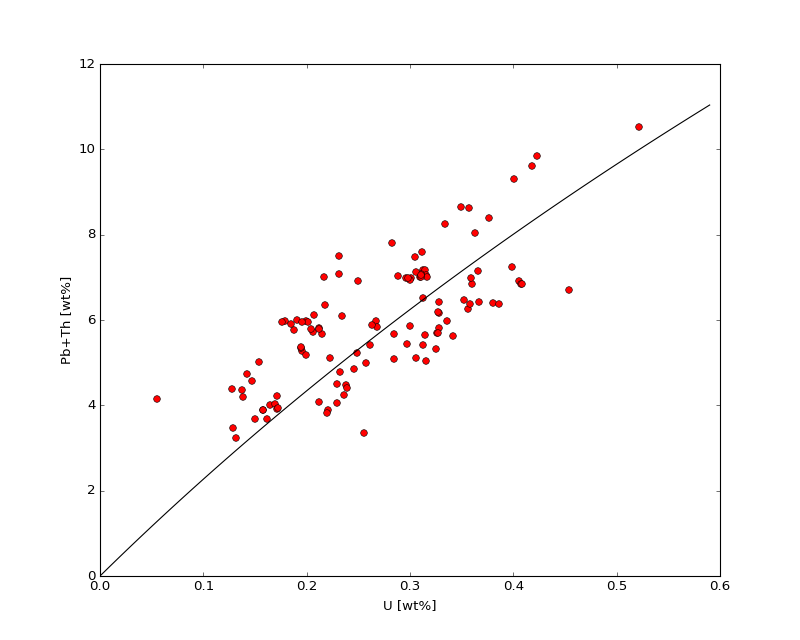

In [109]:
line_x = np.arange(0.,0.6,0.01)
plt.plot(weight_KZ.U,weight_KZ.Th+weight_KZ.Pb,'ro')
plt.plot(line_x,(np.log2(1+line_x)*16.5),'k-') #logaritmic line
#plt.plot(line_x,line_x*12/0.565,'k-')  #simple line
plt.xlim(0)
plt.xlabel('U [wt%]')
plt.ylabel('Pb+Th [wt%]')
plt.ylim(0)
plt.show()

Lets make subdivision:

In [112]:
subset1 = weight_KZ[weight_KZ.Pb + weight_KZ.Th > np.log2(1+weight_KZ.U)*16.5] #0.565
subset2 = weight_KZ[weight_KZ.Pb + weight_KZ.Th <= np.log2(1+weight_KZ.U)*16.5] # 0.565
subset1_stddev = stddev_KZ[weight_KZ.Pb + weight_KZ.Th > np.log2(1+weight_KZ.U)*16.5]
subset2_stddev = stddev_KZ[weight_KZ.Pb + weight_KZ.Th <= np.log2(1+weight_KZ.U)*16.5]

In [115]:
np.average(subset1['Age (Ma)'], weights=1/subset1['Age err']), np.average(subset2['Age (Ma)'], weights=1/subset2['Age err'])

(334.73884207504574, 315.34922348078516)


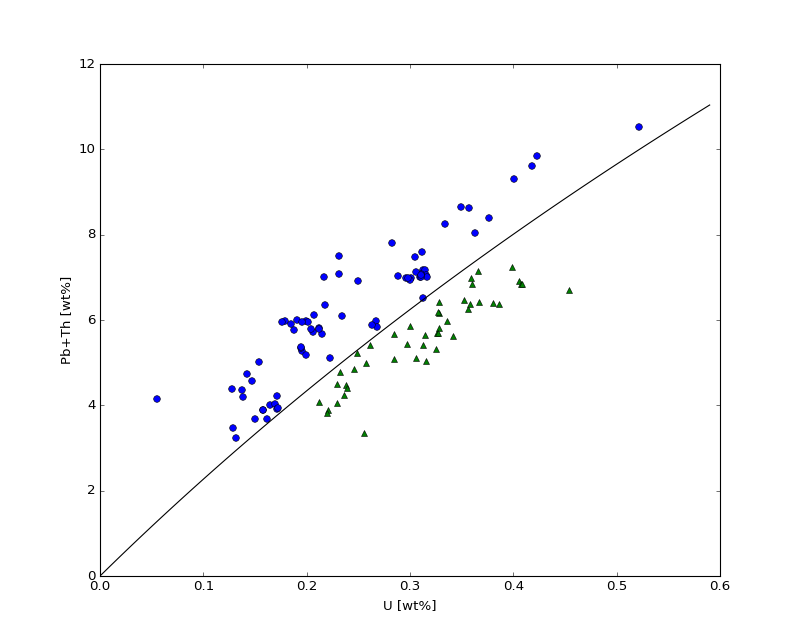

In [118]:
line_x = np.arange(0.,0.6,0.01)
plt.plot(subset1.U,subset1.Th+subset1.Pb,'bo')
plt.plot(subset2.U,subset2.Th+subset2.Pb,'g^')
#plt.plot(subset3.U,subset3.Th+subset3.Pb*Pb_cor_cof,'rd')
plt.plot(line_x,(np.log2(1+line_x)*16.5),'k-') #logaritmic line
plt.xlim(0)
plt.xlabel('U [wt%]')
plt.ylabel('Pb+Th [wt%]')
plt.ylim(0)
plt.show()

lets see how it looks in Th/Pb vs U/Pb plot:

In [60]:
plt.close()


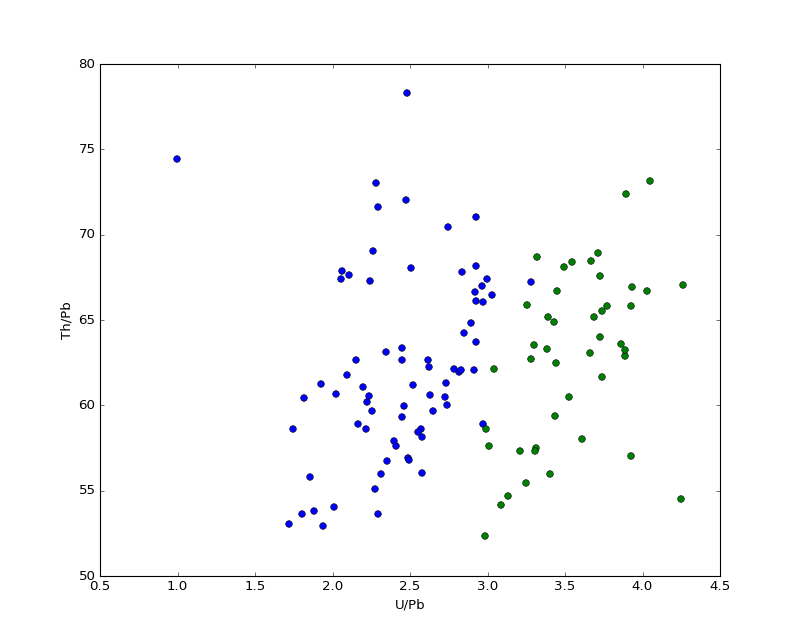

In [116]:
plt.plot(subset1.U/subset1.Pb*Pb_cor_cof,subset1.Th/subset1.Pb*Pb_cor_cof,'o')
plt.plot(subset2.U/subset2.Pb*Pb_cor_cof,subset2.Th/subset2.Pb*Pb_cor_cof,'o')
plt.xlabel('U/Pb')
plt.ylabel('Th/Pb')
plt.show()

In [62]:
plt.close()

how does it looks in Th,U,Pb 3D space?:


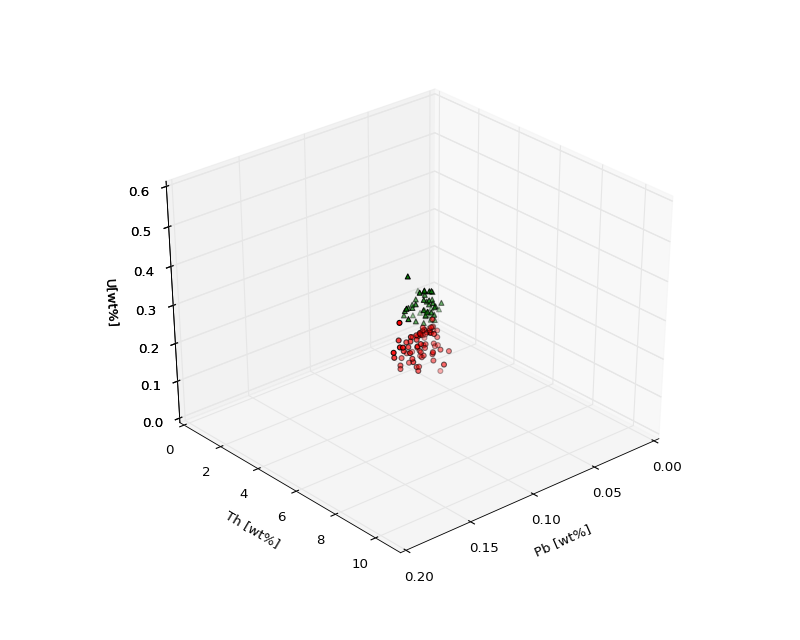

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(subset1.Pb*Pb_cor_cof, subset1.Th, subset1.U,
           c='r', marker='o')
ax.scatter(subset2.Pb*Pb_cor_cof, subset2.Th, subset2.U,
           c='g', marker='^')
ax.set_xlabel('Pb [wt%]')
ax.set_ylabel('Th [wt%]')
ax.set_zlabel('U[wt%]')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_zlim(0)
plt.show()
ax.view_init(elev=33, azim=49)
plt.draw()

looks good!

In [130]:
plt.close()

lets check if there is visible differences in age populations of subselected groups:


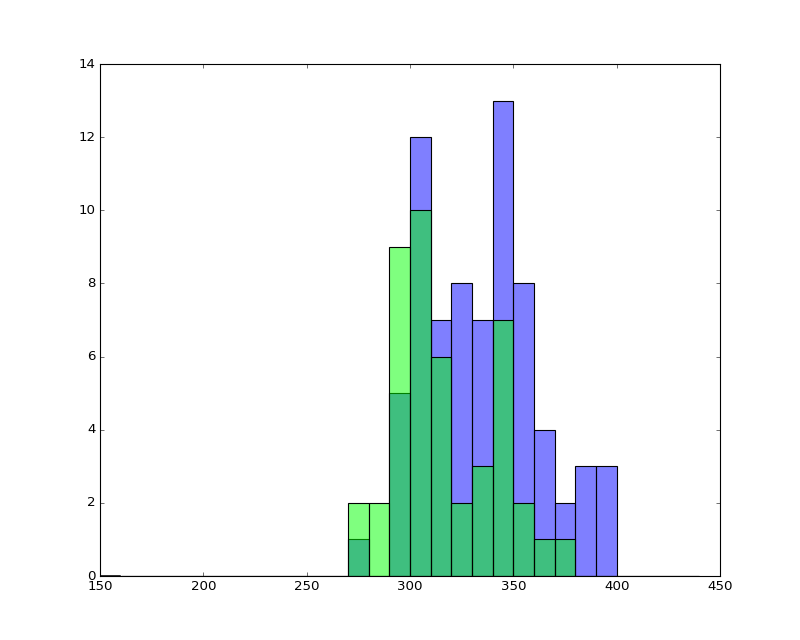

In [129]:
plt.hist(np.asanyarray(subset1['Age (Ma)']),bins=np.arange(150.,450.,10),color=(0,0,1,0.5))
plt.hist(np.asanyarray(subset2['Age (Ma)']),bins=np.arange(150.,450.,10),color=(0,1,0,0.5))
plt.show()

In [128]:
plt.close()

Is there tendency of age distribution and our new subgroups?:


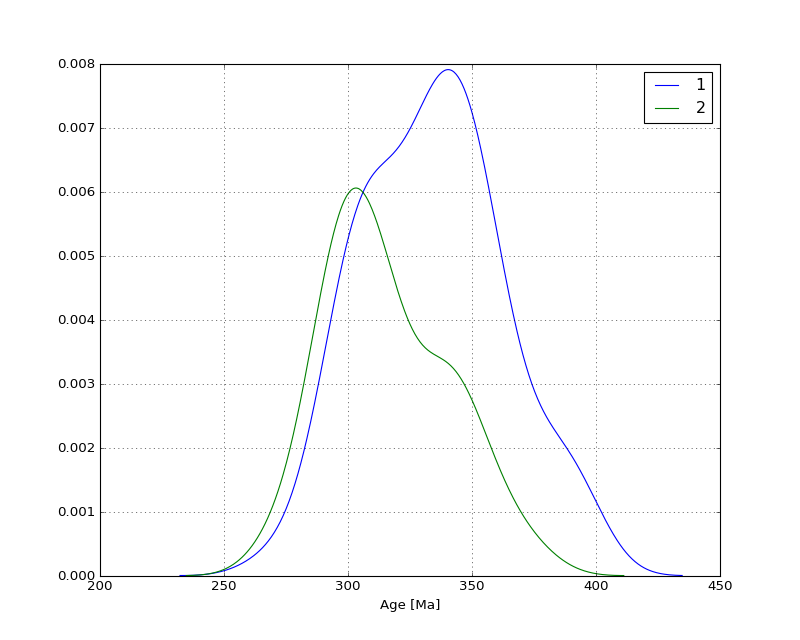

In [133]:
gausianUTh = sm.nonparametric.KDEUnivariate(np.asanyarray(subset1['Age (Ma)'],dtype=np.double))
gausianUTh.fit()
plt.plot(gausianUTh.support,gausianUTh.density*subset1['Age (Ma)'].count()/weight_KZ['Age (Ma)'].count(),label='1')
gausianUTh = sm.nonparametric.KDEUnivariate(np.asanyarray(subset2['Age (Ma)'],dtype=np.double))
gausianUTh.fit()
plt.plot(gausianUTh.support,gausianUTh.density*subset2['Age (Ma)'].count()/weight_KZ['Age (Ma)'].count(),label='2')
plt.grid()
plt.xlabel('Age [Ma]')
plt.legend()

the groups is still overlapping, but there is clear dominance of ages-- 1st group ~350-340, 2nd ~305-315Ma. By reducing gausian kde bandwith we can reveal more details:


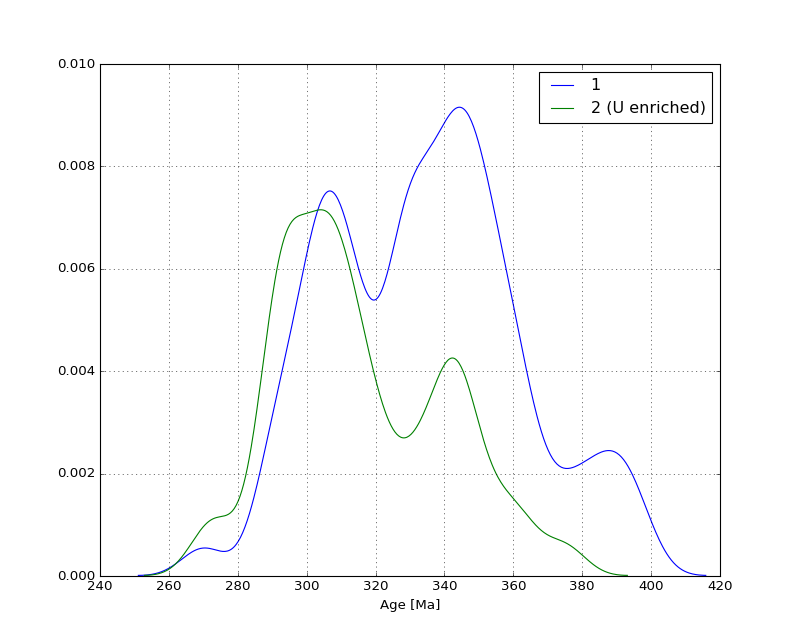

In [183]:
gausianUTh = sm.nonparametric.KDEUnivariate(np.asanyarray(subset1['Age (Ma)'],dtype=np.double))
gausianUTh.fit(adjust=0.5)  #<-- adjusted this
plt.plot(gausianUTh.support,gausianUTh.density*subset1['Age (Ma)'].count()/weight_KZ['Age (Ma)'].count(),label='1')
gausianUTh = sm.nonparametric.KDEUnivariate(np.asanyarray(subset2['Age (Ma)'],dtype=np.double))
gausianUTh.fit(adjust=0.5)  #<-- adjusted this
plt.plot(gausianUTh.support,gausianUTh.density*subset2['Age (Ma)'].count()/weight_KZ['Age (Ma)'].count(),label='2 (U enriched)')
plt.grid()
plt.xlabel('Age [Ma]')
plt.legend()

That graph above tells a lot and makes very big sense:
1. Group 1 have lower U content than group 2
2. Both groups overlap and marks the same 2-3 thermal events
3. U enriched monazites crystalysed delayed at every event (which makes sense)    

In [135]:
plt.close()

In [136]:
subset_list = [subset1, subset2]


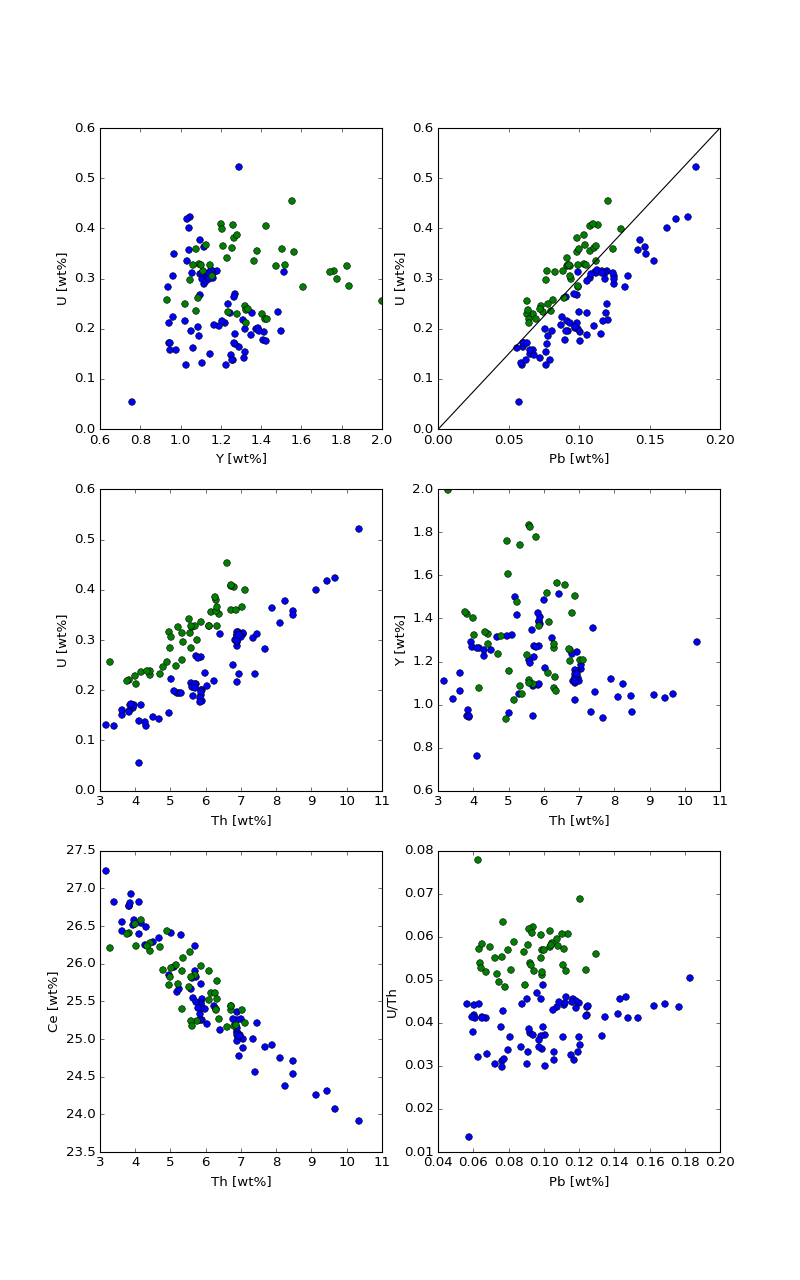

In [137]:
fig = plt.figure(figsize=(10,16))
ax1 = fig.add_subplot(321)
for i in subset_list:
    ax1.plot(i.Y,i.U,'o')
ax1.set_xlabel('Y [wt%]')
ax1.set_ylabel('U [wt%]')
ax2 = fig.add_subplot(322)
for i in subset_list:
    ax2.plot(i.Pb,i.U,'o')
ax2.plot((0,0.2),(0.0,0.6),'k-')
ax2.set_xlabel('Pb [wt%]')
ax2.set_ylabel('U [wt%]')
ax2.set_xlim(0)
ax3 = fig.add_subplot(323)
for i in subset_list:
    ax3.plot(i.Th,i.U,'o')
ax3.set_xlabel('Th [wt%]')
ax3.set_ylabel('U [wt%]')
ax4 = fig.add_subplot(324)
for i in subset_list:
    ax4.plot(i.Th,i.Y,'o')
ax4.set_xlabel('Th [wt%]')
ax4.set_ylabel('Y [wt%]')
ax5 = fig.add_subplot(325)
for i in subset_list:
    ax5.plot(i.Th, i.Ce,'o')
ax5.set_xlabel('Th [wt%]')
ax5.set_ylabel('Ce [wt%]')
ax6 = fig.add_subplot(326)
for i in subset_list:
    ax6.plot(i.Pb,
         i.U/i.Th,'o')
ax6.set_xlabel('Pb [wt%]')
ax6.set_ylabel('U/Th')
plt.show()

###### 5.Time to do some curve fitting:

In [138]:
#1. convert weight percents to millications:
cations = pd.DataFrame()
cations.Pb = weight.Pb*208

#### population linear fitting:

for line fitting we would use ortogonal distance regression from scipy:

In [139]:
from scipy import odr

at first we define simple linear function:

In [149]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

now we are creating the model:

In [141]:
linear = odr.Model(f)

In [156]:
# preparing the data:
mydata1 = odr.RealData(subset1.U, subset1.Pb, sx=subset1_stddev.U, sy=subset1_stddev.Pb)
mydata2 = odr.RealData(subset2.U, subset2.Pb, sx=subset2_stddev.U, sy=subset2_stddev.Pb)

In [158]:
# setting up data and model:
myodr = odr.ODR(mydata1, linear,beta0=[1,0])
myodr2 = odr.ODR(mydata2, linear, beta0=[1,0])
myodr.set_job(fit_type=0)
myodr2.set_job(fit_type=0)

In [159]:
# doing the fit
myoutput = myodr.run()
myoutput2 = myodr2.run()

In [160]:
myoutput.pprint()

Beta: [ 0.32030754  0.02494597]
Beta Std Error: [ 0.01798309  0.00457062]
Beta Covariance: [[ 0.00163612 -0.00039243]
 [-0.00039243  0.00010569]]
Residual Variance: 0.19765698180462343
Inverse Condition #: 0.10298013183491402
Reason(s) for Halting:
  Sum of squares convergence


In [161]:
myoutput2.pprint()

Beta: [ 0.25483398  0.01222555]
Beta Std Error: [ 0.02073195  0.00658819]
Beta Covariance: [[ 0.00494799 -0.00154346]
 [-0.00154346  0.00049967]]
Residual Variance: 0.08686637138311026
Inverse Condition #: 0.04789820567256393
Reason(s) for Halting:
  Sum of squares convergence


and ploting:


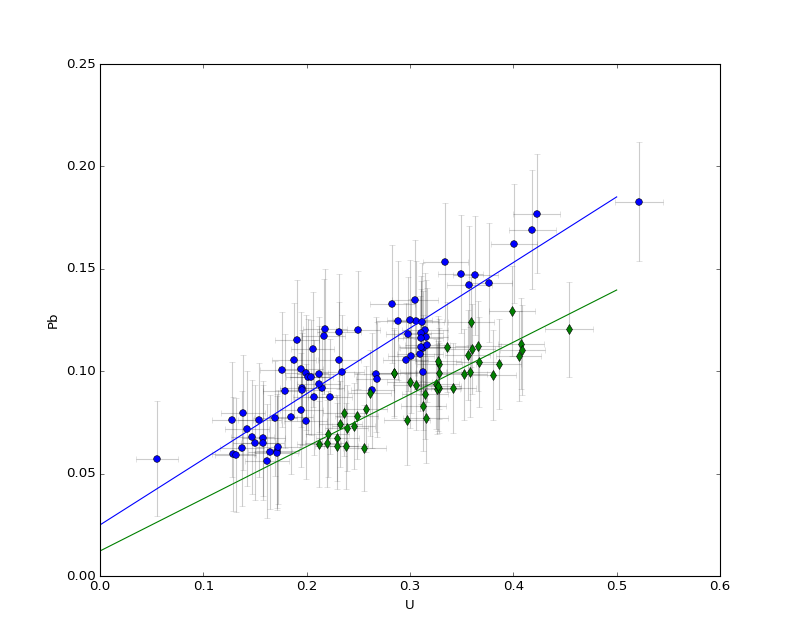

In [165]:
plt.errorbar(subset1.U,subset1.Pb,yerr=np.asanyarray(subset1_stddev.Pb),xerr=np.asanyarray(subset1_stddev.U),fmt='o',ecolor=(0,0,0,0.2))
xn1 = np.arange(0,1,0.5)
yn1 = f(myoutput.beta, xn1)
plt.plot(xn1,yn1,'b-')

plt.errorbar(subset2.U,subset2.Pb,yerr=np.asanyarray(subset2_stddev.U),xerr=np.asanyarray(subset2_stddev.U),fmt='d',ecolor=(0,0,0,0.2))
#plt.plot(subset2.U,subset2.Pb,'d')
xn2 = np.arange(0,1,0.5)
yn2 = f(myoutput2.beta, xn2)
plt.plot(xn2,yn2,'g-')

plt.xlim(0)
plt.ylim(0)
plt.xlabel('U')
plt.ylabel('Pb')
plt.show()